In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import glob
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras import backend as K

from PIL import Image

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

In [5]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
DATA_PATH = '/a/data/fisheries_monitoring/data/'

In [6]:
aug_folders = glob.glob(DATA_PATH + 'localizers/*')
for i, folder in enumerate(aug_folders):
    print "index:", i, '\t', "folder name:", folder

index: 0 	folder name: /a/data/fisheries_monitoring/data/localizers/splice
index: 1 	folder name: /a/data/fisheries_monitoring/data/localizers/invert
index: 2 	folder name: /a/data/fisheries_monitoring/data/localizers/vflip
index: 3 	folder name: /a/data/fisheries_monitoring/data/localizers/add
index: 4 	folder name: /a/data/fisheries_monitoring/data/localizers/emboss
index: 5 	folder name: /a/data/fisheries_monitoring/data/localizers/gaussianNoise
index: 6 	folder name: /a/data/fisheries_monitoring/data/localizers/blur
index: 7 	folder name: /a/data/fisheries_monitoring/data/localizers/original
index: 8 	folder name: /a/data/fisheries_monitoring/data/localizers/dropout
index: 9 	folder name: /a/data/fisheries_monitoring/data/localizers/rotate


In [9]:
aug_folders = aug_folders[1:]

In [10]:
aug_folders

['/a/data/fisheries_monitoring/data/localizers/vflip',
 '/a/data/fisheries_monitoring/data/localizers/add',
 '/a/data/fisheries_monitoring/data/localizers/emboss',
 '/a/data/fisheries_monitoring/data/localizers/gaussianNoise',
 '/a/data/fisheries_monitoring/data/localizers/blur',
 '/a/data/fisheries_monitoring/data/localizers/original',
 '/a/data/fisheries_monitoring/data/localizers/dropout',
 '/a/data/fisheries_monitoring/data/localizers/rotate']

In [11]:
def load_all_labels(aug_folders):
    all_labels = pd.DataFrame(columns = ["img", "x","y","w","h"])
    for folder in aug_folders:
        folder_name = os.path.basename(folder)
        print "Loading data augmentation folder:", folder_name
        labels = pd.read_csv(folder + '/superboxes.csv', names = ["img", "x","y","w","h"])
        labels = labels.sort_values(by = "img")
        labels["img"] = folder_name + '/' + labels["img"]
        print "Number of examples:", len(labels)
        print
        all_labels = all_labels.append(labels)
    print "total number of examples: ", len(all_labels)
    return all_labels


def train_val_test_split(all_labels, val_size, test_size):
    all_labels = shuffle(all_labels, random_state = 8574)
    test_labels = all_labels[0:test_size]
    val_labels = all_labels[test_size:test_size + val_size]
    train_labels = all_labels[test_size + val_size:]
    return train_labels, val_labels, test_labels


def data_generator(batch_size, labels, INPUT_WIDTH, INPUT_HEIGHT):
    while True:
        img_batch = np.zeros((batch_size, INPUT_WIDTH, INPUT_HEIGHT, 3))
        box_batch = np.zeros((batch_size, 4))
        for i in xrange(batch_size):
            n = np.random.choice(len(labels))
            file_name = labels.iloc[n]["img"]
            path = DATA_PATH + 'localizers/' + file_name
            img = image.load_img(path)
            width, height = img.size
            img = img.resize((INPUT_WIDTH, INPUT_HEIGHT))
            img = image.img_to_array(img)
            img /= 255
            img_batch[i] = img
            
            old_x, old_y, old_w, old_h = labels.iloc[n][["x","y","w","h"]]
            new_x = old_x / width
            new_y = old_y / height
            new_w = old_w / width
            new_h = old_h / height
            box = np.array([new_x, new_y, new_w, new_h])
            box_batch[i] = box
        
        yield (img_batch, box_batch)


def load_data(labels, INPUT_WIDTH, INPUT_HEIGHT):
    X = []
    y = []
    idx = []
    X_raw = []
    y_raw = [] 
    shape_raw = []
    for i in xrange(len(labels)):
        file_name = labels.iloc[i]["img"]
        path = DATA_PATH + 'localizers/' + file_name
        img_raw = image.load_img(path)
        width, height = img_raw.size
        img = img_raw.resize((INPUT_WIDTH,INPUT_HEIGHT))
        
        img_raw = image.img_to_array(img_raw)
        img_raw /= 255
        img = image.img_to_array(img)
        img /= 255
        
        old_x, old_y, old_w, old_h = labels.iloc[i][["x","y","w","h"]]
        new_x = old_x / width
        new_y = old_y / height
        new_w = old_w / width
        new_h = old_h / height

        X.append(img)
        y.append(np.array([new_x, new_y, new_w, new_h]))
        idx.append(file_name)
        X_raw.append(img_raw)
        shape_raw.append(np.array([width, height]))
        
        if (i+1) in [k*len(labels)/5 for k in xrange(1,6)]:
                print "Loading...{}% done!".format((i+2)*100/len(labels))
        
    return np.array(X), np.array(y), np.array(idx), np.array(X_raw), np.array(shape_raw)


def visualize_prediction(img, index = None, true_box = None, pred_box = None, ax = None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.imshow(img)
    if index is not None:
        ax.set_title(index)
    height = img.shape[0]
    width = img.shape[1]
    
    if true_box is not None:
        x, y, w, h = true_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='\\',
            fill=False,      # remove background
            color = 'r',
            linewidth = 2.5
                )
            )
    if pred_box is not None:
        x, y, w, h = pred_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='-',
            fill=False,      # remove background
            color = 'k',
            linewidth = 2.5
                )
            )

def make_plot(data, nrow = 2, ncol = 2, index = None, true_box = None, pred_box = None, figsize = (15,8)):
    # Create grid
    _, ax = plt.subplots(nrow, ncol, figsize=figsize)
    
    idx = None
    tbox = None
    pbox = None
    # Generate indices of images to show
    for axi in np.ravel(ax):
        n = np.random.choice(len(data))
        img = data[n]
        if index is not None:
            idx = index[n]
        if true_box is not None:
            tbox = true_box[n]
        if pred_box is not None:
            pbox = pred_box[n]
        
        # Visualize it along with the box
        visualize_prediction(img, index = idx, true_box = tbox, pred_box = pbox, ax = axi)

In [12]:
all_labels = load_all_labels(aug_folders)

Loading data augmentation folder: vflip
Number of examples: 13240

Loading data augmentation folder: add
Number of examples: 6620

Loading data augmentation folder: emboss
Number of examples: 3310

Loading data augmentation folder: gaussianNoise
Number of examples: 9930

Loading data augmentation folder: blur
Number of examples: 6620

Loading data augmentation folder: original
Number of examples: 3310

Loading data augmentation folder: dropout
Number of examples: 6620

Loading data augmentation folder: rotate
Number of examples: 19860

total number of examples:  69510


In [25]:
selected_aug = {"ALB" : ["original", "rotate", "vflip"],
                "BET" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
                "DOL" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
                "LAG" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
#                 "NoF" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
                "OTHER" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
                "SHARK" : ["original", "rotate", "vflip", "invert", "add", "emboss", "gaussianNoise", "blur", "dropout"],
                "YFT" : ["original", "rotate", "vflip", "invert", "add", "emboss", "blur", "dropout"]}
selected_labels = pd.DataFrame(columns = ["img", "x","y","w","h"])
for key, values in selected_aug.iteritems():
    for value in values:
        labels_tmp = all_labels[all_labels["img"].str.startswith(value + '/' + key)]
        selected_labels = selected_labels.append(labels_tmp)

Size of original data: 3310 	Size of augmented data: 50138 	times augmented: 15.1474320242
For each class:
Original size: 1717 	After augmentation: ALB 18887 	times augmented: 11.0
Original size: 200 	After augmentation: BET 4200 	times augmented: 21.0
Original size: 117 	After augmentation: DOL 2457 	times augmented: 21.0
Original size: 67 	After augmentation: LAG 1407 	times augmented: 21.0
Original size: 299 	After augmentation: OTHER 6279 	times augmented: 21.0
Original size: 176 	After augmentation: SHARK 3696 	times augmented: 21.0
Original size: 734 	After augmentation: YFT 13212 	times augmented: 18.0


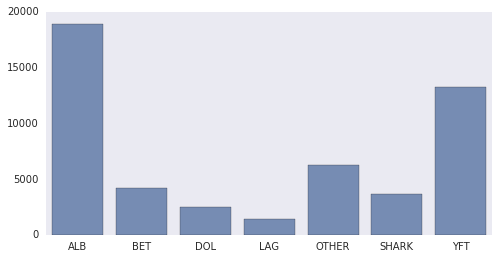

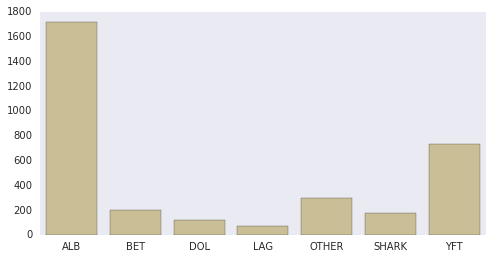

In [26]:
train_files = all_labels[all_labels["img"].str.startswith("original")]["img"]

categories = np.array([name[9:-14] for name in train_files])
cat = pd.Series(categories).value_counts()
cat = cat.sort_index()

count = {}
for key in selected_aug:
    count[key] = len(selected_labels[selected_labels["img"].str.contains(key)])
count = pd.Series(count)
plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8, color=p[0])
plt.figure(figsize=(8,4))
sns.barplot(cat.index, cat.values, alpha=0.8, color=p[4])
print "Size of original data:", len(train_files), '\t', "Size of augmented data:", len(selected_labels), \
      "\t", "times augmented:", len(selected_labels)/float(len(train_files))
print "For each class:"
for key in count.index:
    print "Original size:", cat[key], '\t', "After augmentation:", key, count[key], \
          '\t', "times augmented:", float(count[key])/cat[key]

In [23]:
train_labels, val_labels, test_labels = train_val_test_split(selected_labels, 10000, 5000)

In [32]:
X_test, y_test, id_test, X_test_raw, shape_raw = load_data(test_labels, INPUT_WIDTH, INPUT_HEIGHT)

Loading...20% done!
Loading...40% done!
Loading...60% done!
Loading...80% done!
Loading...100% done!


## Visualizing data

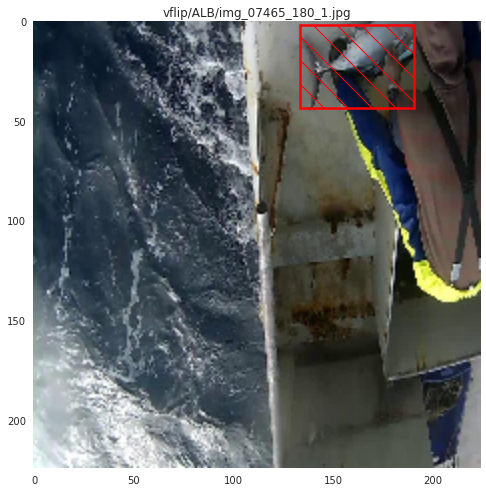

In [33]:
make_plot(data = X_test, nrow = 1, ncol = 1, index = id_test, true_box = y_test, figsize = (15,8))

## Define model

In [28]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(INPUT_WIDTH, INPUT_HEIGHT,3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation = 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error')

## Start training

In [29]:
batch_size = 30
steps_per_epoch = 100
nb_epoch = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),]

model.fit_generator(generator = data_generator(batch_size, train_labels, INPUT_WIDTH, INPUT_HEIGHT), 
                    steps_per_epoch = steps_per_epoch,
                    epochs=nb_epoch,
                    verbose=1,
#                     callbacks = callbacks,
                    validation_data = data_generator(batch_size, val_labels, INPUT_WIDTH, INPUT_HEIGHT),
                    validation_steps = 30)
model.save(DATA_PATH + 'models/localizers/ResNet50_SuperBox.h5')

Epoch 1/30


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib64/python2.7/threading.py", line 811, in __bootstrap_inner
    self.run()
  File "/usr/lib64/python2.7/threading.py", line 764, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/a/h/jli04/Envs/deep-venv/lib/python2.7/site-packages/keras/engine/training.py", line 606, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-11-19bc95b28343>", line 32, in data_generator
    img = image.load_img(path)
  File "/a/h/jli04/Envs/deep-venv/lib/python2.7/site-packages/keras/preprocessing/image.py", line 320, in load_img
    img = pil_image.open(path)
  File "/a/h/jli04/Envs/deep-venv/lib/python2.7/site-packages/PIL/Image.py", line 2249, in open
    fp = builtins.open(filename, "rb")
IOError: [Errno 13] Permission denied: '/a/data/fisheries_monitoring/data/localizers/rotate/YFT/img_02845_135.jpg'



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

## Prediction and visualization

In [55]:
model = load_model(DATA_PATH + 'models/localizers/ResNet50_SuperBox.h5')
y_pred = model.predict(X_test.astype('float32'), verbose=1)
print "test loss:", mean_squared_error(y_test, y_pred)

1000/1000 [==============================] - 12s     

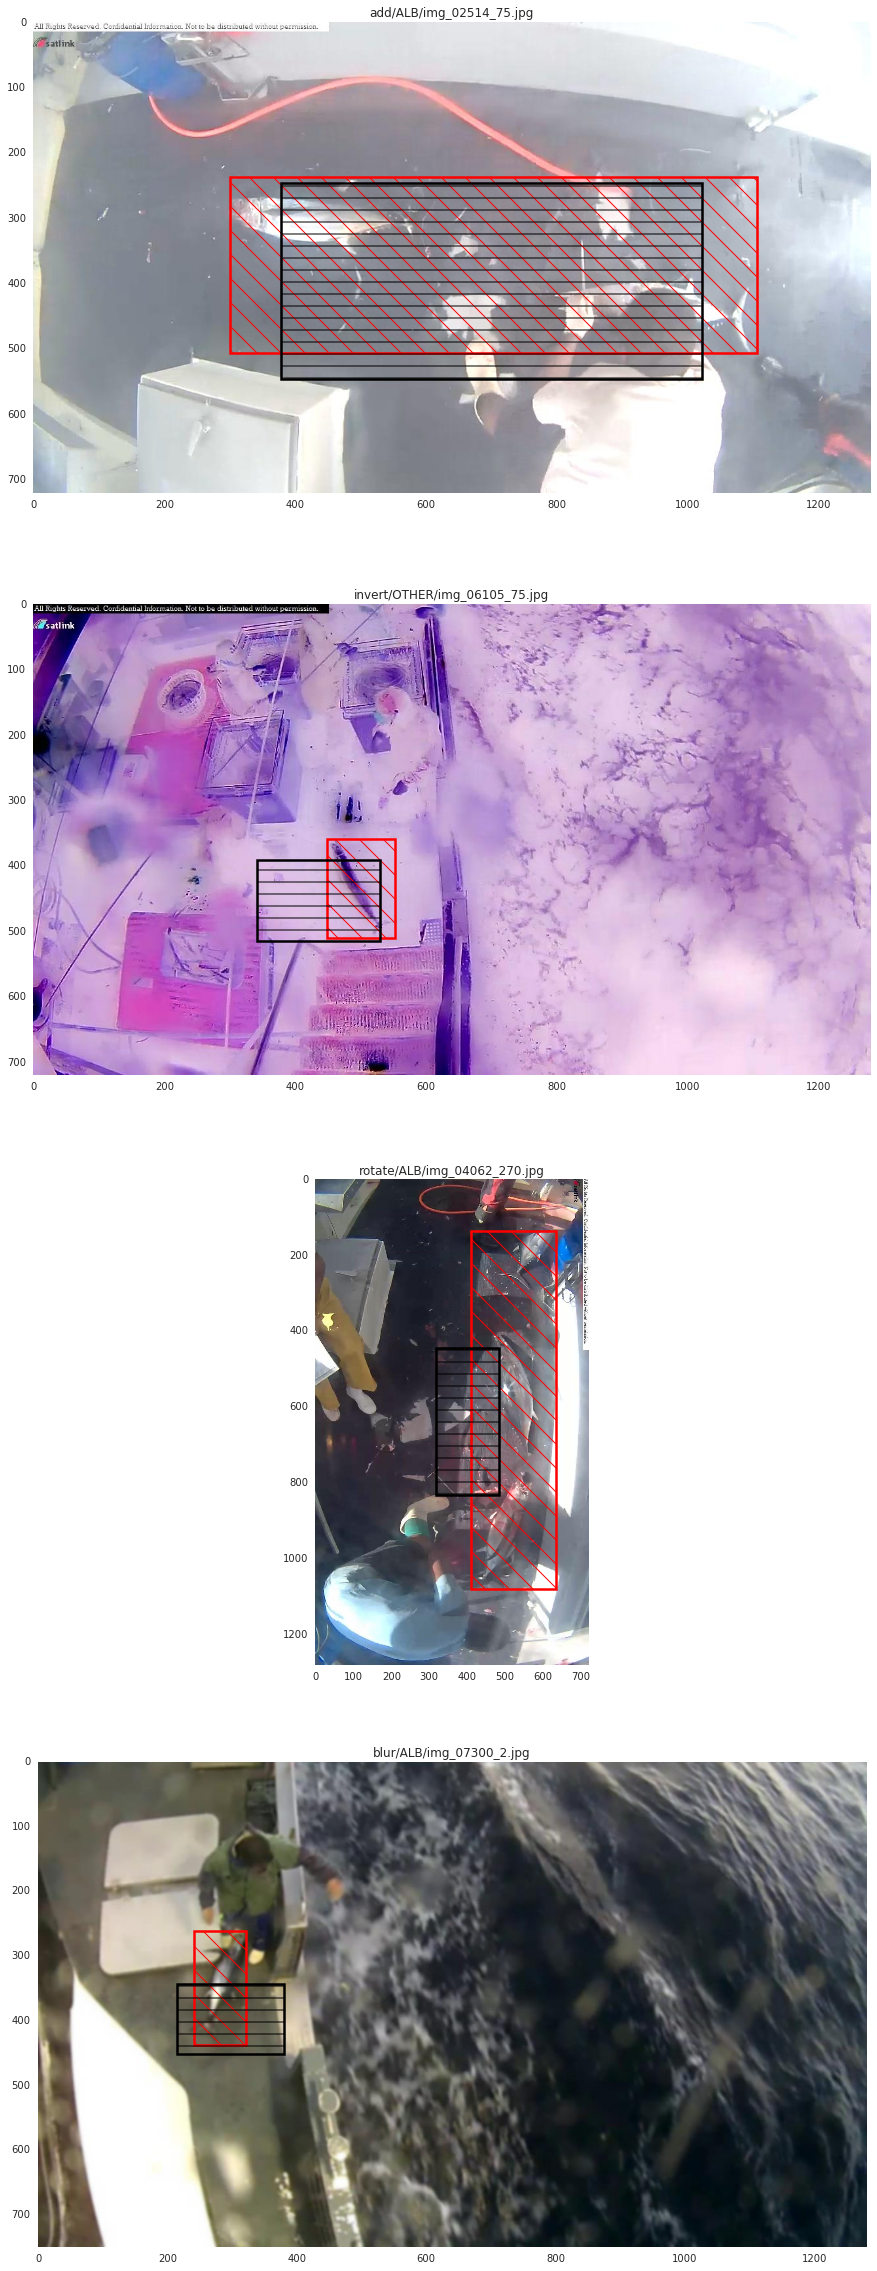

In [57]:
# The true boxes have the patch pattern of '\\' and predicted boxes have the patch pattern of '-'
make_plot(data = X_test_raw,
          nrow = 4, 
          ncol = 1, 
          index = id_test, 
          true_box = y_test, 
          pred_box = y_pred, 
          figsize = (15, 40))